<a href="https://colab.research.google.com/github/joaoAngelo2/classificacao_citacoes/blob/main/Modelo_classifica%C3%A7%C3%A3o_cita%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rota da apresentação:

Dados crus $\rightarrow$ Limpeza inicial + Feature Engineering $\rightarrow$ EDA $\rightarrow$ Modelagem

In [ ]:
!pip install deep-translator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 2.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np
#importando os gráficos
import seaborn as sns
import matplotlib.pyplot as plt

#transforma palavra -> vetor numérico
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from tqdm import tqdm #temporaziador
import time
import requests
import ast


from deep_translator import GoogleTranslator #tradutor

# Os dados "crus":

In [ ]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/RBIE/SBIE20/SBIE20 - Produções/Dataset/sbie_2001_2024.csv')

print(df.head)

Mounted at /content/drive
<bound method NDFrame.head of                                                     url   ano  \
0     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
1     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
2     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
3     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
4     https://www.br-ie.org/pub/index.php/sbie/downl...  2019   
...                                                 ...   ...   
3219  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3220  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3221  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3222  https://sol.sbc.org.br/index.php/sbie/article/...  2020   
3223  https://sol.sbc.org.br/index.php/sbie/article/...  2020   

                                                 titulo  \
0         Elementos pré-textuais e comitês do SBIE 2019   
1     Uma Análise do Sequenciamento Pedagógic

# Realizando a limpeza inicial dos dados






In [ ]:

#preenchendo valores não coletados
df['citacoes'] = df['citacoes'].fillna(0)

#removendo informações
df = df[
         ~(df['titulo'].str.startswith('Contra-capa') |
         df['titulo'].str.startswith('Capa dos anais'))
         | df['titulo'].str.startswith('Editorial')
         | df['titulo'].str.startswith('Elementos pré-textuais')]

df['citacoes'] = df['citacoes'].astype(int)
#removendo artigos sem resumo
df  = df[df['resumo'].notna()]


In [ ]:


def parse_afiliacoes(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return []
    elif isinstance(x, list):
        return x
    else:
        return []

df['afiliacoes'] = df['afiliacoes'].apply(parse_afiliacoes)

todas_instituicoes = set()
for aff_list in df['afiliacoes']:
    if isinstance(aff_list, list):
        for autor in aff_list:
            if isinstance(autor, dict) and 'id_afiliacoes' in autor:
                todas_instituicoes.update(autor['id_afiliacoes'])

print(f"Total de instituições únicas: {len(todas_instituicoes)}")

def get_nome_instituicao(openalex_id):
    if not openalex_id:
        return None
    inst_id = openalex_id.split('/')[-1]
    url = f'https://api.openalex.org/institutions/{inst_id}'
    resp = requests.get(url)
    if resp.status_code == 200:
        data = resp.json()
        return data.get('display_name', None)
    return None

instituicao_nomes = {}
for inst_id in tqdm(todas_instituicoes, desc="Buscando nomes no OpenAlex"):
    nome = get_nome_instituicao(inst_id)
    instituicao_nomes[inst_id] = nome if nome else inst_id

for inst_id, nome in instituicao_nomes.items():
    nome_limpo = nome.replace(" ", "_").replace(",", "").replace(".", "")
    col_name = nome_limpo[:50]  # limitar tamanho se necessário
    df[col_name] = 0

for idx, aff_list in df['afiliacoes'].items():
    if isinstance(aff_list, list):
        ids = set()
        for autor in aff_list:
            if isinstance(autor, dict) and 'id_afiliacoes' in autor:
                ids.update(autor['id_afiliacoes'])
        for inst_id in ids:
            nome = instituicao_nomes.get(inst_id, inst_id)
            nome_limpo = nome.replace(" ", "_").replace(",", "").replace(".", "")
            col_name = nome_limpo[:50]
            df.at[idx, col_name] = 1


Total de instituições únicas: 439


Buscando nomes no OpenAlex: 100%|██████████| 439/439 [00:22<00:00, 19.60it/s]
/tmp/ipython-input-3137068455.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = 0
/tmp/ipython-input-3137068455.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[col_name] = 0
/tmp/ipython-input-3137068455.py:42: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To

In [ ]:
print(instituicao_nomes.values())

dict_values(['Instituto de Ensinos Superiores da Amazônia', 'University of Lisbon', 'Cisco Systems (United States)', 'Design Science (United States)', 'Federal Center for Technological Education Celso Suckow da Fonseca', 'Southwest Bahia State University', 'Universidade Federal de Roraima', 'Universidade Federal de São Paulo', "Agence pour le développement de l'emploi", 'Fundação de Amparo à Pesquisa do Estado de Minas Gerais', 'Instituto Federal de Educação, Ciência e Tecnologia de Mato Grosso', 'Amadeu Antonio Foundation', 'Universidade Federal de Ciências da Saúde de Porto Alegre', 'Universidade Federal de Alagoas', 'Sociedade Brasileira de Educação Matemática', 'https://openalex.org/I4210148226', 'https://openalex.org/I4210164547', 'Universidade Cruzeiro do Sul', 'https://openalex.org/I139221136', 'https://openalex.org/I4210104689', 'https://openalex.org/I4210157461', 'https://openalex.org/I121374431', 'Hospital Municipal Souza Aguiar', 'https://openalex.org/I4210160027', 'https://

# Coletando o "Corpus" titulo + resumo para transformação em vetores numéricos

In [ ]:
corpus = (df['resumo'] + df['titulo']).to_list()

Realizando a normalização do corpus PT $\rightarrow$ EN

In [ ]:
tradutor = GoogleTranslator(source='pt', target='en')

def traduzir_texto(texto):
    try:
        traducao = tradutor.translate(texto)
        time.sleep(0.1)
        return traducao
    except Exception as e:
        return ""

corpus_traduzido = []

for texto in tqdm(corpus, desc="Traduzindo artigos", ncols=100):
    corpus_traduzido.append(traduzir_texto(texto))


Traduzindo artigos: 100%|███████████████████████████████████████| 3214/3214 [11:22<00:00,  4.71it/s]



Binarizando o nosso **target** $y$
---
$
y =
\begin{cases}
0, & \text{se citações } \leq  \text{mediana} \\
1, & \text{caso contrário }
\end{cases}
\ $


In [ ]:
mediana = (int(df['citacoes'].median()))

df['citacoes'] = df['citacoes'].apply(lambda x: 0 if x <= mediana else 1)

print(df['citacoes'].value_counts(normalize=True))

citacoes
0    0.606098
1    0.393902
Name: proportion, dtype: float64


Ajustando desequilibrio

In [ ]:

contagem = df['citacoes'].value_counts()
classe_0 = 0
classe_1 = 1

if contagem[0] > contagem[1]:
    majoritaria = 0
    minoritaria = 1
else:
    majoritaria = 1
    minoritaria = 0

target = contagem[minoritaria]

indices_remover = []


for idx, linha in df.iterrows():
    if linha['citacoes'] == majoritaria and len(indices_remover) < (contagem[majoritaria] - target):
        indices_remover.append(idx)

df_balanceado = df.drop(indices_remover)


In [ ]:
vectorizer = TfidfVectorizer(max_features=1000, stop_words='english') #pegando as 1000 palavras mais relevantes
X_text = vectorizer.fit_transform(corpus_traduzido)

In [ ]:
X_text_df = pd.DataFrame(X_text.toarray(), columns=vectorizer.get_feature_names_out())
X_text_df.reset_index(drop=True, inplace=True)
X_text_df = X_text_df.drop(indices_remover).reset_index(drop=True)

In [ ]:
df_completo = pd.concat([
    df_balanceado.reset_index(drop=True),
    X_text_df.reset_index(drop=True)
], axis=1)

# Análise exploratória dos dados


**Passo 1**: Entendimento dos dados


*   Visão geral dos dados (*shape, head, tail, sample, dtypes*)
*   resumo estatístico (*describe*)


**Passo 2**: limpeza e organização dos dados

*   Apagar colunas e linhas desnecessárias
*   Identificar colunas duplicadas
*   Corrigir nomes, valores etc.
*   Renomear colunas

**Passo 3**: Gráfico para entender as variáveis

*   Variáveis quantitativas: histogramas, KDE, *boxplots*
*   Variáveis qualitativas: gráficos de colunas, barras, linha, pizza

**Passo 4**: Relação entre variáveis

*   Diagramas de dispersão
*   Mapas de calor (*heatmaps*)
*   Agrupamento de dados: *groupby*

**Passo 5**: Elaborar uma questão sobre os dados



##### fontes:
https://www.each.usp.br/lauretto/SIN5008_2011/aula01/aula1.pdf

https://www.youtube.com/watch?v=woObL4Mx9ns


In [ ]:
df_completo.head()

,url,ano,titulo,autores,resumo,id_paper,citacoes,afiliacoes,Faculdades_Integradas_de_São_Paulo,Universidade_Federal_de_Uberlândia,...,use,used,user,users,uses,using,virtual,way,web,work
0,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Uma Análise do Sequenciamento Pedagógico no En...,"['Nathalia Alves', 'Christiane Gresse von Wang...",Several curriculum frameworks have been propos...,https://openalex.org/W2991363149,1,"[{'nome': 'Nathalia da Cruz Alves', 'id_autor'...",0,0,...,0.000000,0.113379,0.0,0.0,0.0,0.109943,0.0,0.0,0.0,0.000
1,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Autenticidade na aprendizagem baseada em proje...,"['Vinícius Ferreira', 'Edna Canedo']",Este trabalho apresenta uma revisão sistemátic...,https://openalex.org/W2991619052,1,"[{'nome': 'V.F. Ferreira', 'id_autor': 'https:...",0,0,...,0.000000,0.164635,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.069
2,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Online Student Engagement: A Case Study in Tea...,"['Mirna Carelli Maia', 'Jorge César Abrantes d...",Technological support changed the teaching-lea...,https://openalex.org/W2989674602,1,"[{'nome': 'Mirna Carelli Oliveira Maia', 'id_a...",0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000
3,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Aprendizagem baseada em projetos aplicada em u...,"['Ricardo Ajax Kosloski', 'Cristiane Ramos', '...",This paper presents an experience case report ...,https://openalex.org/W2991110921,1,"[{'nome': 'Ricardo Ajax Dias Kosloski', 'id_au...",0,0,...,0.067259,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000
4,https://www.br-ie.org/pub/index.php/sbie/downl...,2019,Small Private Online Courses in Computing Lear...,"['Jorge Prates', 'Rogerio Garcia', 'José Maldo...",SPOCs (Small Private Online Courses) are consi...,https://openalex.org/W2989857383,1,"[{'nome': 'Jorge Prates', 'id_autor': 'https:/...",0,0,...,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000


In [ ]:
df_completo.describe()

,ano,citacoes,Faculdades_Integradas_de_São_Paulo,Universidade_Federal_de_Uberlândia,Consejo_Nacional_de_Investigaciones_Científicas_y_,Hospital_de_Clínicas_da_Unicamp,Universidade_Católica_de_Petrópolis,Central_University_of_Venezuela,Laureate_Education,Brazilian_Computer_Society,...,use,used,user,users,uses,using,virtual,way,web,work
count,2532.000000,2532.000000,2532.000000,2532.000000,2532.0,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,...,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000,2532.000000
mean,2014.268562,0.500000,0.000395,0.016588,0.0,0.009479,0.000395,0.000790,0.000790,0.000395,...,0.047375,0.034802,0.016542,0.016323,0.011354,0.036980,0.039508,0.018331,0.025404,0.040479
std,7.158128,0.500099,0.019873,0.127746,0.0,0.096915,0.019873,0.028099,0.028099,0.019873,...,0.073260,0.063080,0.062940,0.062417,0.046090,0.067796,0.101439,0.054711,0.088641,0.057731
min,2001.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2008.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2015.000000,0.500000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2021.000000,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.085528,0.074534,0.000000,0.000000,0.000000,0.072862,0.000000,0.000000,0.000000,0.081789
max,2024.000000,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.525519,0.519714,0.678080,0.657961,0.385908,0.567140,0.755715,0.557432,0.839106,0.490881


In [ ]:
df_completo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2532 entries, 0 to 2531
Columns: 631 entries, ano to work
dtypes: float64(200), int64(430), object(1)
memory usage: 12.2+ MB


Número de dados nulos por coluna

In [ ]:
df_completo.isna().sum()

,0
ano,0
citacoes,0
Faculdades_Integradas_de_São_Paulo,0
Universidade_Federal_de_Uberlândia,0
Consejo_Nacional_de_Investigaciones_Científicas_y_,0
...,...
using,0
virtual,0
way,0
web,0


# Criando gráficos

## Análise qualitativa

<Axes: xlabel='ano'>

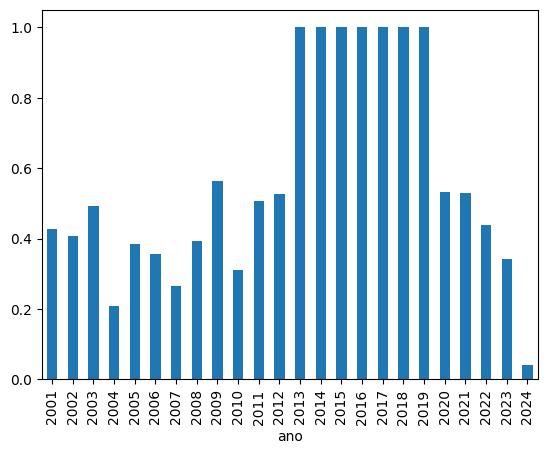

In [ ]:
df_completo.groupby('ano')['citacoes'].mean().plot(kind='bar')

<Axes: >

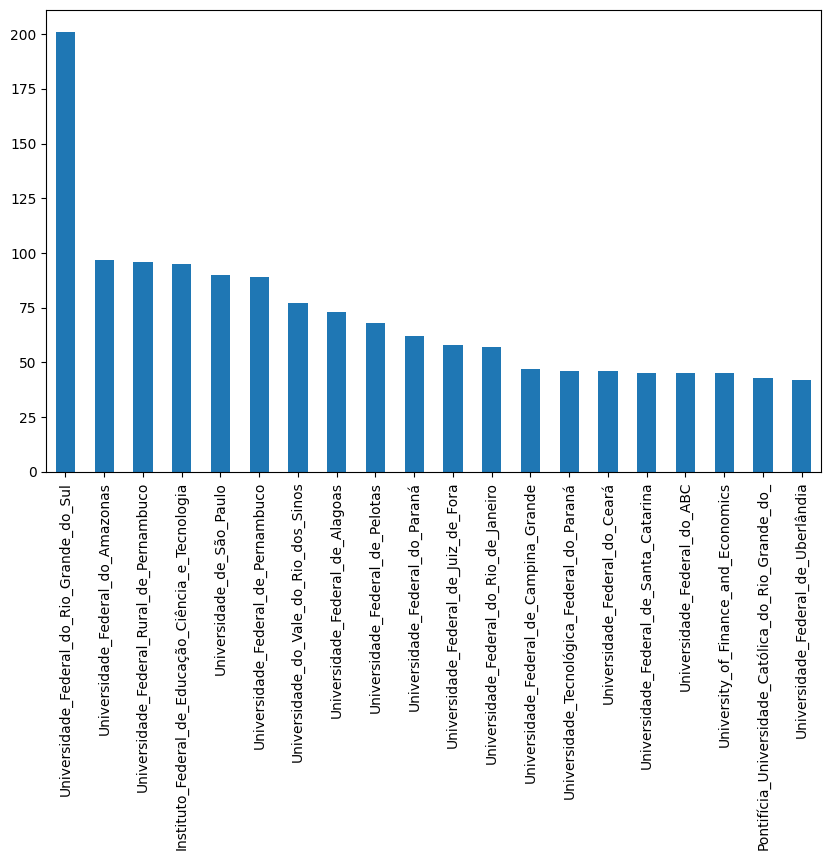

In [ ]:
# gráfico de pizza distribuição de universidades -> apresentamos somente as 20 mais por conta da quantidade
plt.figure(figsize=(10,6))
top_universidades = df_completo.iloc[:, 3:425].sum().sort_values(ascending=False).head(20)
top_universidades.plot(kind='bar')

<Axes: >

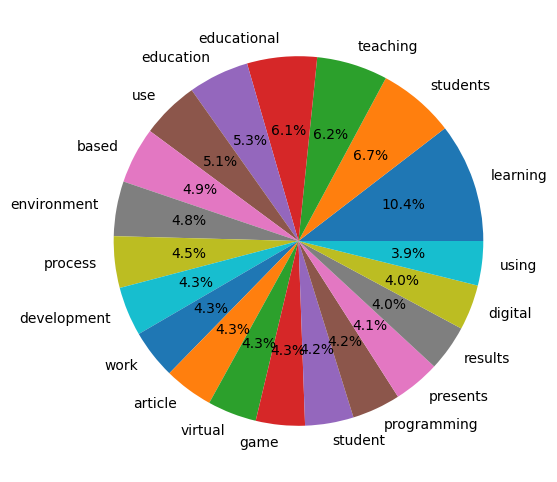

In [ ]:
#gráfico de distribuição de palavras 40 mais pq sao muitas
plt.figure(figsize=(10,6))
top_palavras = df_completo.iloc[:, 426:].sum().sort_values(ascending=False).head(20)
top_palavras.plot(kind='pie', autopct='%1.1f%%')

## Análise quantitativa

In [ ]:
muito_citado = df_completo[df_completo['citacoes'] == 1]
baixo_citado = df_completo[df_completo['citacoes'] == 0]

colunas_tf = df_completo.columns[442:1439]

freq_bem = muito_citado[colunas_tf].mean().sort_values(ascending=False)
freq_baixo = baixo_citado[colunas_tf].mean().sort_values(ascending=False)

comparativo = pd.DataFrame({
    "freq_bem_citado": freq_bem,
    "freq_pouco_citado": freq_baixo,
    "diferenca": freq_bem - freq_baixo
}).sort_values("diferenca", ascending=False)

comparativo.head(10)


,freq_bem_citado,freq_pouco_citado,diferenca
gamification,0.021010,0.008175,0.012835
games,0.035006,0.022248,0.012758
systematic,0.026833,0.014678,0.012155
mobile,0.019108,0.009011,0.010097
objects,0.029321,0.020046,0.009275
game,0.041275,0.032159,0.009116
techniques,0.020508,0.012211,0.008297
mapping,0.019739,0.011735,0.008004
application,0.028205,0.020403,0.007802
programming,0.041605,0.033945,0.007659


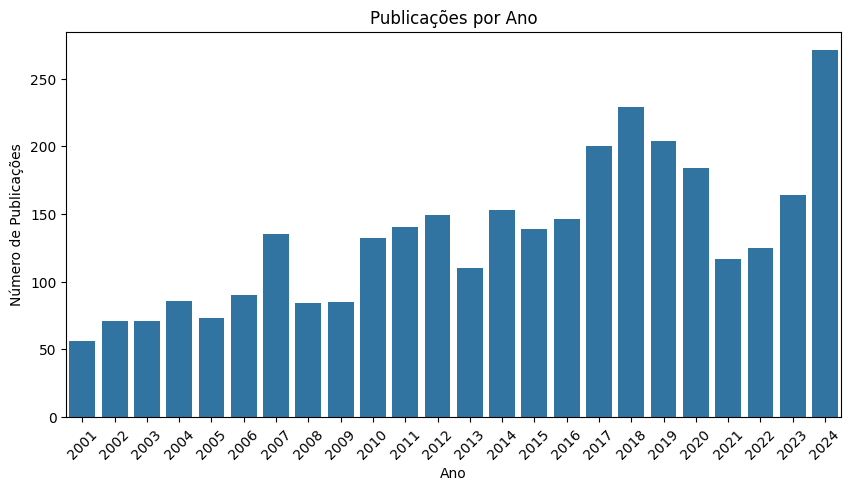

In [ ]:
publicacoes_por_ano = df.groupby('ano').size()

plt.figure(figsize=(10,5))
sns.barplot(x=publicacoes_por_ano.index, y=publicacoes_por_ano.values)
plt.title("Publicações por Ano")
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.xticks(rotation=45)
plt.show()

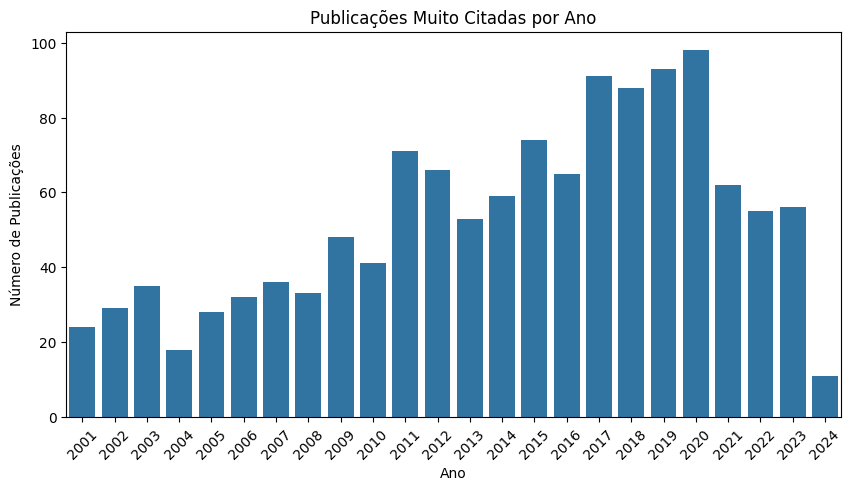

In [ ]:
muito_citado = df_completo[df_completo['citacoes'] == 1]
muito_citado = muito_citado.groupby('ano').size()

plt.figure(figsize=(10,5))
sns.barplot(x=muito_citado.index, y=muito_citado.values)
plt.title("Publicações Muito Citadas por Ano")
plt.xlabel("Ano")
plt.ylabel("Número de Publicações")
plt.xticks(rotation=45)
plt.show()

# Criando o modelo classificador - SVM

In [ ]:
df_completo.to_csv("df_final.csv")

In [ ]:
df_completo = pd.read_csv("/content/df_final.csv")

In [ ]:
X =  df_completo.iloc[:,:426]
X = X.drop(columns=['Unnamed: 0', 'citacoes','ano'])
y = df_completo['citacoes']

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(
    X_otimizado, y, test_size=0.3, stratify=y, random_state=42
)


In [ ]:
clf = SVC(kernel='rbf')

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.6960526315789474


In [ ]:

tfidf_cols = df_completo.iloc[:, 426:]
col_sums = tfidf_cols.sum(axis=0)

top_cols = col_sums.sort_values(ascending=False).head(400).index


tfidf_top = tfidf_cols[top_cols]

X_base = df_completo.iloc[:, :426]
X_otimizado = pd.concat([X_base, tfidf_top], axis=1)

print(f"Formato final: {X_otimizado.shape}")


Formato final: (2532, 826)


# Otimização de hiperparametros $→$ parâmetros definidos antes do treinamento: quantidade de palavras importantes, C, kernel...




Fazendo os imports

In [ ]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

fonte : https://medium.com/@sibelasgarova/gridsearchcv-and-randomsearchcv-in-svm-cda2dad8e434

In [ ]:
parametros = {

    'C': [0.1, 1, 10],
    'gamma': [0.01, 0.1, 1],
    'kernel': ['rbf', 'poly']
}

svc = SVC()

randomsearch_svm = RandomizedSearchCV(estimator=svc, param_distributions=parametros,n_iter=5, scoring='accuracy', cv=5,n_jobs=-1)

randomsearch_svm.fit(X_train, y_train)

print(randomsearch_svm.best_params_)

y_pred = randomsearch_svm.best_estimator_.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print(f"\nAcurácia: {acc:.4f}")
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))


{'kernel': 'poly', 'gamma': 1, 'C': 1}

Acurácia: 1.0000
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       380
           1     1.0000    1.0000    1.0000       380

    accuracy                         1.0000       760
   macro avg     1.0000    1.0000    1.0000       760
weighted avg     1.0000    1.0000    1.0000       760

[[380   0]
 [  0 380]]


RandomForest $→$ número de árvores, profundidade máxima do nó...

In [ ]:
parametros_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [2, 4],
}

rfc = RandomForestClassifier(random_state=42)

randomsearch_rf = RandomizedSearchCV(estimator=rfc, param_distributions=parametros_rf,n_iter=5, scoring='accuracy', cv=5,n_jobs=-1)



randomsearch_rf.fit(X_train, y_train)

y_pred = randomsearch_rf.best_estimator_.predict(X_test)

print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0     0.9896    1.0000    0.9948       380
           1     1.0000    0.9895    0.9947       380

    accuracy                         0.9947       760
   macro avg     0.9948    0.9947    0.9947       760
weighted avg     0.9948    0.9947    0.9947       760

[[380   0]
 [  4 376]]


In [ ]:

parametros_mlp = {
    'hidden_layer_sizes': [(64,32), (64), (64,32,16)],
    'activation': ['relu', 'tanh','lbfgs'],
    'solver': ['adam', 'sgd']
}


mlp = MLPClassifier(random_state=42)


randomsearch_mlp = RandomizedSearchCV(
    estimator=mlp,
    param_distributions=parametros_mlp,
    n_iter=5,
    scoring='accuracy',
    cv=5,
    random_state=42,
    n_jobs=-1,
    verbose=2
)

randomsearch_mlp.fit(X_train, y_train)
print("Melhores:", randomsearch_mlp.best_params_)

y_pred = randomsearch_mlp.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Melhores: {'solver': 'adam', 'hidden_layer_sizes': (64, 32), 'activation': 'relu'}
              precision    recall  f1-score   support

           0     0.8460    0.9974    0.9155       380
           1     0.9968    0.8184    0.8988       380

    accuracy                         0.9079       760
   macro avg     0.9214    0.9079    0.9072       760
weighted avg     0.9214    0.9079    0.9072       760

[[379   1]
 [ 69 311]]


In [ ]:
# Três parâmetros mais comuns
parametros_dt = {
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'criterion': ['gini', 'entropy', 'log_loss']
}

dt = DecisionTreeClassifier(random_state=42)

randomsearch_dt = RandomizedSearchCV(
    estimator=dt,
    param_grid=parametros_dt,
    scoring='accuracy',
    cv=5,
    n_jobs=-1,
    verbose=2
)


randomsearch_dt.fit(X_train, y_train)


y_pred = randomsearch_dt.best_estimator_.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))
print(confusion_matrix(y_test, y_pred))

Fitting 5 folds for each of 36 candidates, totalling 180 fits
              precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       380
           1     1.0000    1.0000    1.0000       380

    accuracy                         1.0000       760
   macro avg     1.0000    1.0000    1.0000       760
weighted avg     1.0000    1.0000    1.0000       760

[[380   0]
 [  0 380]]
